<a href="https://colab.research.google.com/github/sirr890/Denoising-Images/blob/main/DenoisingImage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torchvision.datasets as datasets
from torchvision.transforms import ToTensor
import numpy as np
import imageio
from torch.utils.data import Dataset, DataLoader
from skimage import io, transform
from torchvision import transforms, utils
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

In [ ]:
#.... Download COCO data set...
!wget http://images.cocodataset.org/zips/test2014.zip

#...Unzip...
!unzip test2014.zip

torch.Size([3, 256, 256])


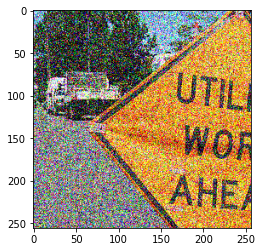

In [17]:
import glob

#...Create data set with noise...
class RandomCrop(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image = sample[0]
        groundtruth = sample[1]
        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        # pading if image smaller than crop size
        if h < new_h:        
          image=np.pad(image,((new_h-h+1,0),(0,0),(0,0)),mode='reflect')
          groundtruth=np.pad(groundtruth,((new_h-h+1,0),(0,0),(0,0)),mode='reflect')
        if w < new_w:        
          image=np.pad(image,((0,0),(new_w-w+1,0),(0,0)),mode='reflect')
          groundtruth=np.pad(groundtruth,((0,0),(new_w-w+1,0),(0,0)),mode='reflect')

        h, w = image.shape[:2]

        top = np.random.randint(0, h - new_h)       
        left = np.random.randint(0, w - new_w)
        image = image[top: top + new_h,
                      left: left + new_w]
        groundtruth = groundtruth[top: top + new_h,
                      left: left + new_w]
        return image, groundtruth

class MyImage(Dataset):
  def __init__(self, ind_init, ind_final, transform=None):
    super().__init__()
    seg_path = []
    gt_path = []
    i=-1
    path = "test2014/*.jpg"
    for seq in glob.iglob(path):
      i+=1
      if i>=ind_init and i<ind_final:
        seg_path.append(seq)
    self.seg_path = seg_path
    self.leng = len(seg_path)
    self.transform = transform

  def __len__(self):
    return self.leng

  def __getitem__(self, index):
    img = imageio.imread(self.seg_path[index])
    x = img

    if self.transform:
            sample = [img, x]
            img, x = self.transform(sample)         
    
    img = np.rollaxis(img, 2) 
    x = np.rollaxis(x, 2)
    img = torch.from_numpy(img).float()
    x = torch.from_numpy(x).long()
    img = img/255.0
    # add noise
    img = img + (0.1**0.5)*torch.randn(img.shape[0], img.shape[1], img.shape[2])
    img = torch.clip(img,0,1)    
    x = x/255.0
    return img, x

# create data set
cropsize=256
Traindata = MyImage(0,200, transform=transforms.Compose([
                                                   RandomCrop(cropsize)
                                            ]))

# print first image of the Traindata dataset
img, y = Traindata[0]
print(img.shape)
plt.imshow(np.transpose(img, (1, 2, 0)))

In [18]:
#...UNet definition...

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )   

class UNet(nn.Module):

    def __init__(self):
        super().__init__()
                
        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, 3, 1)
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        x = self.dconv_down4(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        x = self.conv_last(x)
        
        return x

In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs

In [ ]:
#...Train step...

# set hyper-parameter
learning_rate = 1e-3
n_epochs = 500
batch_size = 2
writer = SummaryWriter()
images = torch.utils.data.DataLoader(Traindata, batch_size = batch_size, shuffle = True)

net = UNet()
device = torch.device('cuda:0')
net = net.to(device)
criterion = nn.L1Loss()
criterion = criterion.to(device)
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
for epoch in range(n_epochs):  # loop over the data set multiple times

    running_loss = 0.0
    for i, data in enumerate(images):

        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if (i == 0):
          writer.add_scalar('Loss/epoch',loss.item(), epoch)
          writer.add_image('labels', labels[0,:,:,:], epoch)
          writer.add_image('input', inputs[0,:,:,:], epoch)
          writer.add_image('outputs', outputs[0,...], epoch)
          writer.flush()
          if (epoch%100==0 and epoch!=0): # save model every 100 epochs...
            torch.save({'net':net.state_dict()},'unet'+str(epoch)+'.pt')
print('Finished Training')

(-0.5, 511.5, 511.5, -0.5)

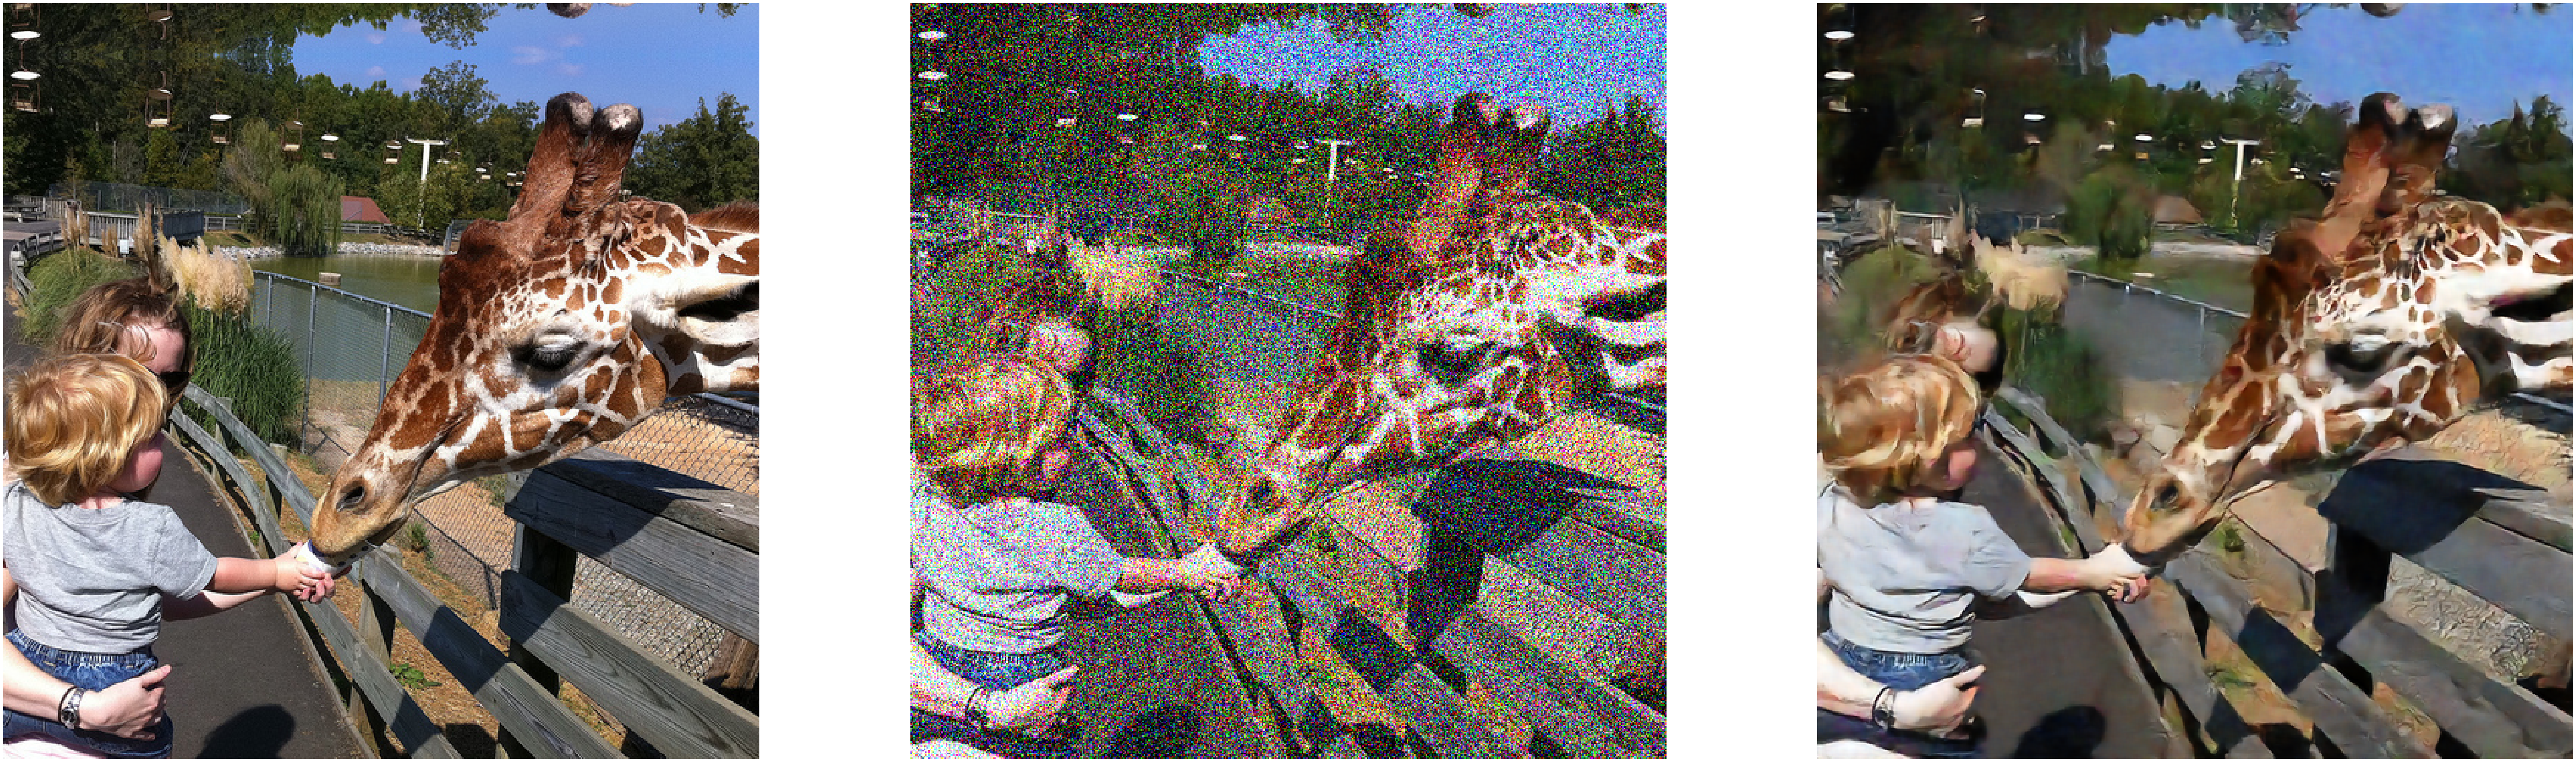

In [144]:
#...Test stage...

net = UNet()
device = torch.device('cuda:0')
net = net.to(device)

st = torch.load('unet200.pt')
weights = st['net']
net.load_state_dict(weights)

net.eval()

test_init = 200
test_final = 300

dataset = MyImage(test_init, test_final,transform=transforms.Compose([
                                                   RandomCrop(512)
                                            ]))                             
image, groundtruth = dataset[1]
image = image.unsqueeze(0) 
image = image.to(device)
groundtruth = groundtruth.to(device)
predicted = net(image)

# plot real image, image with noise and image without noise returned by the model
f, axarr = plt.subplots(1,3,figsize=(100,100))
axarr[0].imshow(np.transpose(groundtruth.to('cpu'),(1,2,0)))
axarr[0].axis('off')
axarr[1].imshow(np.transpose(image.to('cpu')[0,...],(1,2,0)))
axarr[1].axis('off')
predicted_show=np.clip(np.array(predicted[0,...].detach().cpu().numpy()),0,1)
axarr[2].imshow((np.transpose(predicted_show,(1,2,0))))
axarr[2].axis('off')